In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
%matplotlib inline
from sklearn import preprocessing

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus']=False

In [4]:
temp201904 = pd.read_csv("/Users/jaeyoungcho/Desktop/2020 금융 빅데이터 챌린지-공모전데이터/데이터/비씨카드/거래내역_201904.csv", sep=",", encoding="CP949")
temp201905 = pd.read_csv("/Users/jaeyoungcho/Desktop/2020 금융 빅데이터 챌린지-공모전데이터/데이터/비씨카드/거래내역_201905.csv", sep=",", encoding="CP949")
temp202004 = pd.read_csv("/Users/jaeyoungcho/Desktop/2020 금융 빅데이터 챌린지-공모전데이터/데이터/비씨카드/거래내역_202004.csv", sep=",", encoding="CP949")
temp202005 = pd.read_csv("/Users/jaeyoungcho/Desktop/2020 금융 빅데이터 챌린지-공모전데이터/데이터/비씨카드/거래내역_202005.csv", sep=",", encoding="CP949")

job = pd.read_csv("/Users/jaeyoungcho/Desktop/2020 금융 빅데이터 챌린지-공모전데이터/데이터/비씨카드/공통코드.csv", sep=",", encoding="CP949")

In [5]:
# 2019년 4월 데이터에 16일까지 밖에 없어서 2020년 4월 17일 이상 드롭
drop_date = temp202004[temp202004['기준일자'] >= 20200417].index.tolist()
temp202004.drop(drop_date,axis = 0,inplace = True)

In [6]:
# 2019년 5월 데이터에 14일까지 밖에 없어서 2020년 5월 15일 이상 드롭
drop_date = temp202005[temp202005['기준일자'] >= 20200515].index.tolist()
temp202005.drop(drop_date,axis = 0,inplace = True)

### 201904~202005 까지의 데이터는 갯수를 맞춰서 잘라준 듯하다.

### 기본적인 NaN값, 중복값 조회 및 수정

In [7]:
temp201904.drop(['할부개월수'],axis = 1,inplace = True)
temp201905.drop(['할부개월수'],axis = 1,inplace = True)

# 매출금액 예상
> 기대효과 : 매출금액 예상이 높은 사람에게 더 좋은 카드, 더 좋은 혜택을 통해 기존 회원들의 이탈을 방지할 수 있음.

> 2019년의 데이터를 이용해 2020년의 데이터를 예측할 예정

> 19년도 매출금액을 7등급으로 나누고 replace

> 해당 데이터 내에서 train,test 로 나눠 정확도 값 확인

> 적절한 정확도가 나오면 이후 20년도 에 적용

> 같은 feature 들로 20년도 데이터에도 정확도 확인

In [8]:
temp_19 = pd.concat((temp201904,temp201905), axis = 0)
temp_20 = pd.concat((temp202004,temp202005), axis = 0)

In [9]:
temp_19.reset_index(drop=True,inplace = True)
temp_20.reset_index(drop=True,inplace = True)

In [10]:
sex = {'M':0,"F":1}
temp_19.replace(sex, inplace = True)
temp_20.replace(sex, inplace = True)

### 19년도 카드데이터에서 중복값 확인

In [11]:
temp_19.loc[temp_19.duplicated(subset=temp_19.columns)]

,기준일자,가맹점신우편번호,고객신우편번호,생년,연령대코드,성별코드,매출구분코드,가맹점업종코드,매출금액
26113,20190401,8393,12104,1977,40,1,5,4076,187735
26120,20190401,8393,12910,1972,45,0,5,4076,317530
26121,20190401,8393,12910,1977,40,1,5,4076,289392
26122,20190401,8393,12910,1981,35,1,5,4076,283328
26126,20190401,6654,62281,1997,20,0,5,9998,13190
...,...,...,...,...,...,...,...,...,...
2097131,20190514,13606,14600,1958,60,1,5,9153,101500
2097133,20190514,13606,14600,1966,50,0,5,9153,84990
2097134,20190514,13606,14600,1967,50,1,5,9153,90473
2097139,20190514,13606,14613,1974,45,0,5,9153,35254


In [12]:
temp_19.iloc[26113]

기준일자        20190401
가맹점신우편번호        8393
고객신우편번호        12104
생년              1977
연령대코드             40
성별코드               1
매출구분코드             5
가맹점업종코드         4076
매출금액          187735
Name: 26113, dtype: int64

In [13]:
temp_19.loc[(temp_19[temp_19.columns[0]]==20190401) & (temp_19[temp_19.columns[1]]==8393)  & (temp_19[temp_19.columns[2]]==12104)  & (temp_19[temp_19.columns[3]]==1977)  & (temp_19[temp_19.columns[4]]==40)  & (temp_19[temp_19.columns[5]]==0)  & (temp_19[temp_19.columns[6]]==5)  & (temp_19[temp_19.columns[7]]==4076)  & (temp_19[temp_19.columns[8]]==187735)]

,기준일자,가맹점신우편번호,고객신우편번호,생년,연령대코드,성별코드,매출구분코드,가맹점업종코드,매출금액


## 중복데이터가 2097150개 중에서 394268개가 발견됨

#### feature 들의 모든 값이 일치할 수 있는 확률이 존재하지만 그럼에도 불구하고 18.8%, 거의 20%에 달하는 데이터가 중복된다는 건 맞춰주기 위해 의도적으로 늘려 놓은 것으로 확인됨

In [14]:
temp_19.drop_duplicates(inplace= True)

In [15]:
temp_19.reset_index(drop=True,inplace = True)

In [16]:
temp_19

,기준일자,가맹점신우편번호,고객신우편번호,생년,연령대코드,성별코드,매출구분코드,가맹점업종코드,매출금액
0,20190401,6654,14688,1995,25,0,5,9998,128180
1,20190401,6654,14688,1998,20,1,5,9998,14620
2,20190401,6654,14697,1999,20,0,5,9998,32000
3,20190401,6654,14699,1960,60,1,5,9998,17588
4,20190401,6654,14699,1990,30,1,5,9998,41463
...,...,...,...,...,...,...,...,...,...
1702877,20190514,13606,14619,1976,40,1,5,9153,103467
1702878,20190514,13606,14620,1964,55,1,5,9153,106097
1702879,20190514,13606,14621,1958,60,1,5,9153,70097
1702880,20190514,13606,14633,1994,25,1,5,9153,196167


#### 2020년 데이터에는 중복값이 하나도 발견되지 않음. 2019년데이터를 2020년 데이터에 맞춰주기 위해 의도적으로 늘린 것 같다는 의심이 거의 확실시됨

In [17]:
temp_20.loc[temp_20.duplicated(subset=temp_20.columns)]

,기준일자,가맹점신우편번호,고객신우편번호,생년,연령대코드,성별코드,매출구분코드,가맹점업종코드,할부개월수,매출금액


In [18]:
# card 데이터에 합쳐버리기~
card_19 = copy.copy(temp_19)
card_20 = copy.copy(temp_20)

In [19]:
card_19['기준일자'] = card_19['기준일자'].apply(lambda x : x % 10000)
card_20['기준일자'] = card_20['기준일자'].apply(lambda x : x % 10000)

In [20]:
card_19.rename(columns = {'매출금액':'19매출금액','인구수':'유동인구'},inplace = True)

card_20.rename(columns = {'매출금액':'20매출금액','인구수':'유동인구'},inplace = True)

In [21]:
card_20.drop(['할부개월수'],axis = 1,inplace = True)

In [22]:
card_19.drop(['가맹점신우편번호'],axis = 1, inplace = True)
card_20.drop(['가맹점신우편번호'],axis = 1, inplace = True)

In [23]:
card_20.drop(card_20[card_20['20매출금액'] == 31115275].index,axis = 0,inplace = True)

In [24]:
clustering = sorted(card_20['20매출금액'].tolist())
clustering = np.array(clustering)
from sklearn.cluster import KMeans
km = KMeans(n_clusters=7).fit(clustering.reshape(-1,1))

In [25]:
cluster = {}
for i in range(len(clustering)):
    cluster[clustering[i]] = km.labels_[i]

In [26]:
cluster = pd.DataFrame(km.labels_,index=sorted(card_20['20매출금액'].tolist()))

cluster.reset_index(inplace = True)

cluster.rename(columns={'index':'20매출금액'},inplace = True)

In [27]:
cluster.rename(columns={cluster.columns[-1]:'cluster'},inplace = True)

In [28]:
card_20.sort_values(['20매출금액'],inplace = True)
card_20.reset_index(drop=True,inplace = True)

In [29]:
card_20 = pd.concat((card_20,cluster['cluster']),axis = 1)

In [30]:
card_20

,기준일자,고객신우편번호,생년,연령대코드,성별코드,매출구분코드,가맹점업종코드,20매출금액,cluster
0,407,15815,1983,35,1,15,4076,-299833,1
1,403,52349,1985,35,1,19,5123,-274333,1
2,514,10073,1981,40,1,15,4076,-231170,1
3,502,5823,1978,40,1,15,4076,-147630,1
4,407,10111,1979,40,0,15,4076,-141367,1
...,...,...,...,...,...,...,...,...,...
1557589,407,21562,1979,40,1,5,4076,9827193,2
1557590,415,5274,1979,40,0,5,9161,10227507,2
1557591,410,6547,1980,40,0,5,9911,10463391,2
1557592,415,5274,1980,40,0,9,9161,10835500,2


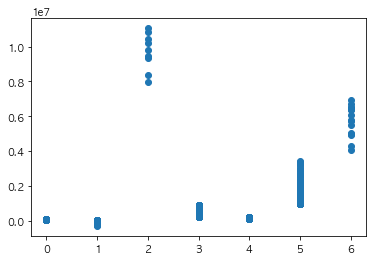

In [31]:
plt.scatter(card_20['cluster'].tolist(),card_20['20매출금액'].tolist())

In [32]:
card_19

,기준일자,고객신우편번호,생년,연령대코드,성별코드,매출구분코드,가맹점업종코드,19매출금액
0,401,14688,1995,25,0,5,9998,128180
1,401,14688,1998,20,1,5,9998,14620
2,401,14697,1999,20,0,5,9998,32000
3,401,14699,1960,60,1,5,9998,17588
4,401,14699,1990,30,1,5,9998,41463
...,...,...,...,...,...,...,...,...
1702877,514,14619,1976,40,1,5,9153,103467
1702878,514,14620,1964,55,1,5,9153,106097
1702879,514,14621,1958,60,1,5,9153,70097
1702880,514,14633,1994,25,1,5,9153,196167


In [43]:
card_20

,기준일자,고객신우편번호,생년,연령대코드,성별코드,매출구분코드,가맹점업종코드,20매출금액,cluster
0,407,15815,1983,35,1,15,4076,-299833,1
1,403,52349,1985,35,1,19,5123,-274333,1
2,514,10073,1981,40,1,15,4076,-231170,1
3,502,5823,1978,40,1,15,4076,-147630,1
4,407,10111,1979,40,0,15,4076,-141367,1
...,...,...,...,...,...,...,...,...,...
1557589,407,21562,1979,40,1,5,4076,9827193,2
1557590,415,5274,1979,40,0,5,9161,10227507,2
1557591,410,6547,1980,40,0,5,9911,10463391,2
1557592,415,5274,1980,40,0,9,9161,10835500,2


In [34]:
card = pd.merge(card_19,card_20, on = ['기준일자','고객신우편번호','연령대코드','성별코드','가맹점업종코드'])

In [35]:
# 최종 모양
card.drop(['20매출금액'],axis = 1,inplace = True)
card.drop(['생년_x','매출구분코드_x','생년_y','매출구분코드_y'],axis = 1,inplace = True)

In [37]:
card.sort_values('cluster',inplace = True)

In [39]:
card.reset_index(drop=True,inplace = True)

In [40]:
card

,기준일자,고객신우편번호,연령대코드,성별코드,가맹점업종코드,19매출금액,cluster
0,410,48046,55,1,9998,28850,0
1,407,30100,45,0,4004,64653,0
2,407,30100,45,0,4004,64653,0
3,407,30100,45,0,4004,64653,0
4,407,30100,45,0,4004,64653,0
...,...,...,...,...,...,...,...
724820,414,46726,40,1,4076,38927,6
724821,513,46726,40,1,4076,40767,6
724822,513,46726,40,1,4076,67343,6
724823,513,46726,40,1,4076,88930,6


In [41]:
card['cluster'].value_counts()

1    573279
0    138521
4     11870
3      1081
5        63
6        11
Name: cluster, dtype: int64

In [95]:
X,y = [card[card.columns[:-1]],card[card.columns[-1]]]

In [96]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state = 42)

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier().fit(X_train,y_train)

In [97]:
rf.score(X_test,y_test)

0.7987804036808631

In [98]:
rf.feature_importances_

array([0.11470782, 0.2284601 , 0.10158994, 0.03761314, 0.18574699,
       0.331882  ])

<BarContainer object of 6 artists>

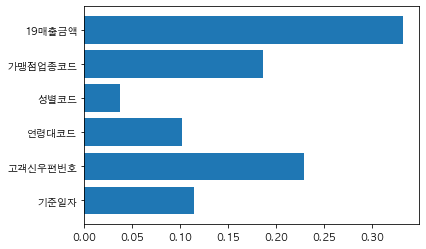

In [99]:
plt.barh(X.columns.tolist(),rf.feature_importances_)

# 교차검증

In [100]:
import sklearn
card = sklearn.utils.shuffle(card)

In [101]:
X,y = [card[card.columns[:-1]],card[card.columns[-1]]]

In [102]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier().fit(X,y)

In [103]:
from sklearn.model_selection import cross_val_score
cross_val_score(rf,X,y,cv = 5)

array([0.79915152, 0.79827545, 0.79762701, 0.79778567, 0.79906874])

In [104]:
from sklearn.model_selection import cross_val_predict
y_predict = cross_val_predict(rf,X,y,cv=3)

In [105]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y,y_predict)

array([[ 61661,     13,      0,   1979,  74880,    133],
       [    36,      0,      0,      5,     21,      1],
       [     3,      0,      0,      1,      7,      0],
       [  5869,      6,      0,   1084,   4888,     29],
       [ 55952,      6,      0,   1578, 515499,     93],
       [   577,      2,      0,     35,    349,    118]])